In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
from line_profiler import LineProfiler

In [4]:
import pandas as pd

In [5]:
%load_ext Cython

In [6]:
def profile_print(func_to_call, *args):
    profiler = LineProfiler()
    profiler.add_function(func_to_call)
    profiler.runcall(func_to_call, *args)
    profiler.print_stats()

In [ ]:
%%cython -a -f --compile-args=-DCYTHON_TRACE=1

import numpy as np
cimport numpy as np
from Cython.Compiler.Options import _directive_defaults

_directive_defaults['linetrace'] = True
_directive_defaults['binding'] = True

# cdef void dot(np.ndarray[np.float64_t, ndim=1] vect, np.ndarray[np.float64_t, ndim=2] X, 
#                                          np.ndarray[np.float64_t, ndim=1] res):
#     for i in range(X.shape[0]):
#         buf = 0.0
#         for j in range(X.shape[1]):
#             buf += X[i, j] * vect[j]
#             res[i] = buf

cdef class RegressionTree:
    cdef public int max_depth
    cpdef RegressionTree left
    cpdef RegressionTree right
    cdef public np.float64_t c
    cdef public np.float64_t value
    cdef public np.float64_t[:] line
    
    def __init__(self, int max_depth=3):
        self.max_depth = max_depth
        self.c = 0.0
        self.value = 0.0
        
        return

    def init_fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):
        self.line = np.zeros(X.shape[1])
        self.line[0] = 1.0
        self.c = X[:, 0].max()

        self.value = y.mean()

    def fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):
        if X.shape[0] <= 1 or self.max_depth <= 1:
            self.value = y.mean()
            return

        self.init_fit(X, y)
    
        # define types of used varibles for cython
        cpdef np.float64_t mean1, mean2, delta1, delta2, sm1, sm2, err1, err2
        cpdef np.float64_t n_line_f, n_c, gamma, buf
        cpdef long N, N1, N2, i, j, idx, f
        cpdef np.ndarray[np.float64_t, ndim=1] u, v
        cpdef np.ndarray[long, ndim=1] idxs
#         cpdef np.ndarray[np.bool, ndim=1] mask1, mask2

        u = np.zeros(X.shape[0])
        v = np.zeros(X.shape[0])

        mask1 = np.zeros(X.shape[0], dtype=bool)
        mask2 = np.zeros(X.shape[0], dtype=bool)
        
        cpdef np.float64_t error = ((y - self.value) ** 2).sum()

        flag = 0
        cpdef np.float64_t left_value = 0.0
        cpdef np.float64_t right_value = 0.0

        for i in range(X.shape[0]):
            v[i] = self.line[0] * X[i, 0]
        
        for f in range(X.shape[1]):
            n_line_f = self.line[f]
            n_c = self.c

            for j in range(3):
                gamma = -0.25 + 0.25 * j
                
                N1 = 0
                N2 = 0
                sm1 = 0.0
                sm2 = 0.0
                mean1 = 0.0
                mean2 = 0.0

                err1 = 0.0
                err2 = 0.0

                for i in range(X.shape[0]):
                    u[i] = v[i] - self.c
                    
                    if abs(X[i, f] + gamma) < 1e-16:
                        if X[i, f] + gamma >= 0.0:
                            u[i] /= (X[i, f] + gamma + 1e-8)
                        else:
                            u[i] /= (X[i, f] + gamma - 1e-8)
                    else:
                        u[i] /= (X[i, f] + gamma)
                    
                    if X[i, f] + gamma < 0:
                        N1 += 1
                        sm1 += y[i]
                    else:
                        N2 += 1
                        sm2 += y[i]
                
                idxs = np.argsort(u)
                
                if N2 != 0:
                    mean2 = sm2 / N2
                if N1 != 0:
                    mean1 = sm1 / N1

                for i in range(X.shape[0]):
                    if X[i, f] + gamma < 0:
                        err1 += (y[i] - mean1) ** 2
                    else:
                        err2 += (y[i] - mean2) ** 2

                if err1 + err2 < error:
                    flag = 1
                    error = err1 + err2
                    left_value = mean1
                    right_value = mean2
                    n_line_f = self.line[f] - (u[idxs[0]] - 0.1)
                    n_c = self.c + (u[idxs[0]] - 0.1) * gamma

                delta1 = 0.0
                delta2 = 0.0
                
                # change left bound of
                for i in range(X.shape[0]):
                    idx = idxs[i]

                    if X[idx, f] + gamma >= 0:
                        N1 += 1
                        N2 -= 1

                        delta1 = (sm1 + y[idx]) * 1.0 / N1 - mean1
                        sm1 += y[idx]
                        err1 += (delta1 ** 2) * N1 + (y[idx] - mean1) ** 2 - 2 * delta1 * (sm1 - mean1 * N1)
                        mean1 = sm1 / N1

                        if N2 != 0:
                            delta2 = (sm2 - y[idx]) * 1.0 / N2 - mean2
                            sm2 -= y[idx]
                            err2 += (delta2 ** 2) * N2 - (y[idx] - mean2) ** 2 - 2 * delta2 * (sm2 - mean2 * N2)
                            mean2 = sm2 / N2
                        else:
                            sm2 = 0.0
                            mean2 = 0.0
                            err2 = 0.0
                    else:
                        N1 -= 1
                        N2 += 1

                        if N1 != 0:
                            delta1 = (sm1 - y[idx]) * 1.0 / N1 - mean1
                            sm1 -= y[idx]
                            err1 += (delta1 ** 2) * N1 - (y[idx] - mean1) ** 2 - 2 * delta1 * (sm1 - mean1 * N1)
                            mean1 = sm1 / N1
                        else:
                            sm1 = 0.0
                            mean1 = 0.0
                            err1 = 0.0

                        delta2 = (sm2 + y[idx]) * 1.0 / N2 - mean2
                        sm2 += y[idx]
                        err2 += (delta2 ** 2) * N2 + (y[idx] - mean2) ** 2 - 2 * delta2 * (sm2 - mean2 * N2)
                        mean2 = sm2 / N2

                    if (i != X.shape[0] - 1) and abs(u[idx] - u[idxs[i + 1]]) < 1e-9:
                        continue

                    if err1 + err2 < error:
                        flag = 1
                        error = err1 + err2
                        left_value = mean1
                        right_value = mean2
                        n_line_f = self.line[f] - u[idx]
                        n_c = self.c + u[idx] * gamma

            self.line[f] = n_line_f
            self.c = n_c
            
            if f == 0:
                for i in range(X.shape[0]):
                    v[i] = self.line[f] * X[i, f]
            else:
                for i in range(X.shape[0]):
                    v[i] += self.line[f] * X[i, f]
        
        N = 0
        for i in range(X.shape[0]):
            if v[i] <= self.c:
                N += 1
                mask1[i] = 1
                mask2[i] = 0
            else:
                mask1[i] = 0
                mask2[i] = 1

        if not flag or N == 0 or N == X.shape[0]:
            return
        
        self.left = RegressionTree(max_depth=self.max_depth - 1)
        self.left.value = left_value
        self.right = RegressionTree(max_depth=self.max_depth - 1)
        self.right.value = right_value
        
        self.left.fit(X[mask1, :], y[mask1])
        self.right.fit(X[mask2, :], y[mask2])

    def __predict(self, x):
        if (self.left is None) or (self.right is None):
            return self.value

        res = np.dot(self.line, x)

        if res <= self.c:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)

    def predict(self, X):
        y = np.zeros(X.shape[0])

        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])

        return y

In [8]:
class GDB:
    def __init__(self, n_epoch=10, max_depth=3, verbose=0):
        self.n_epoch = n_epoch
        self.max_depth = max_depth
        self.error = None
        self.child = None
        self.verbose = verbose
        self.regression_tree = RegressionTree(max_depth=1)
#         self.regression_tree.value = None
        
        # muliplication coeff for regression tree
        self.b = 0.1
        
        # array of values on fitted X
        # self.h = None
        return
    
    def fit(self, X, y):
        if self.n_epoch == 1:
            self.regression_tree.value = y.mean()
            h = np.ones(X.shape[0]) * self.regression_tree.value
            self.b = 1.0
            self.error = ((self.regression_tree.value - y)**2).mean()
            
            if self.verbose == 1:
                print('Epoch ' + str(self.n_epoch) + ' finished')
                print('Error = ', self.error)
            
            return h
        
        self.child = GDB(n_epoch=self.n_epoch - 1, max_depth=self.max_depth, verbose=self.verbose)
        h = self.child.fit(X, y)
        
        g = (y - h)
        a = RegressionTree(max_depth=self.max_depth)
        a.fit(X, g)
        a_values = a.predict(X)
        self.regression_tree = a

#         self.b = 1.0
        h += self.b * a_values
            
        self.error = ((h - y)**2).mean()
        
        if self.verbose == 1:
            print('Epoch ' + str(self.n_epoch) + ' finished')
            print('Error = ', self.error)
        
        return h
    def predict(self, X):
        c = self.b * self.regression_tree.predict(X)
        
#         print('b, pred ', self.b, self.regression_tree.predict(X))
    
        if self.child is not None:
            c += self.child.predict(X)
        
        return c
    
    def _get_scores(self, arr):
        arr.append(self.error)
        if self.child is not None:
            self.child._get_scores(arr)
    def get_scores(self):
        arr = []
        self._get_scores(arr)
        return np.array(arr[::-1])
    
    def staged_scores(self, X, y):
        children = [None for i in range(self.n_epoch)]
        
        gdb_child = self
        i = 0
        while gdb_child is not None:
            children[i] = gdb_child
            gdb_child = gdb_child.child
            i += 1
        
        res = [0 for i in range(self.n_epoch)]
        pred = 0
        for i in range(self.n_epoch):
            pred += children[-i - 1].b * children[-i - 1].regression_tree.predict(X)
            res[i] = ((pred - y) ** 2).mean()
        
        return res

In [9]:
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

import time

In [44]:
t1 = time.time()

gdb = GDB(n_epoch=10, max_depth=4, verbose=1)
gdb.fit(X_norm, y)
print(((gdb.predict(X_norm) - y) **2).mean())

# sk_gdb = GradientBoostingRegressor(n_estimators=10, max_depth=3, learning_rate=0.1, criterion='mse')
# sk_gdb.fit(X, y)
# print(((sk_gdb.predict(X) - y) **2).mean())

print(time.time() - t1)

Epoch 1 finished
Error =  1.33155030008
Epoch 2 finished
Error =  1.16737118015
Epoch 3 finished
Error =  1.0349432843
Epoch 4 finished
Error =  0.926262923697
Epoch 5 finished
Error =  0.833857873983
Epoch 6 finished
Error =  0.758412732124
Epoch 7 finished
Error =  0.697585599147
Epoch 8 finished
Error =  0.646147360982
Epoch 9 finished
Error =  0.603570713103
Epoch 10 finished
Error =  0.567462590266
0.567462590266
3.2713840007781982


In [22]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]], dtype=float)
y = np.array([0, 1, 0, 1], dtype=float)

In [12]:
medians = np.median(X, axis=0)
iqrs = np.subtract(*np.percentile(X, q=[75, 25], axis=0))

X_norm = (X - medians) / iqrs

In [82]:
a = RegressionTree(4)

profile_print(a.fit, *(data_norm[0:100], target[0:100]))

Timer unit: 1e-06 s

Total time: 2.79682 s
File: /Users/dmitry103/.ipython/cython/_cython_magic_d59fa3e4caff39381573ac2d955ecf39.pyx
Function: fit at line 39

Line #      Hits         Time  Per Hit   % Time  Line Contents
    39                                               def fit(self, np.ndarray[np.float64_t, ndim=2] X, np.ndarray[np.float64_t, ndim=1] y):
    40        13           12      0.9      0.0          if X.shape[0] <= 1 or self.max_depth <= 1:
    41         6          211     35.2      0.0              self.value = y.mean()
    42         6           21      3.5      0.0              return
    43                                           
    44         7          488     69.7      0.0          self.init_fit(X, y)
    45                                               
    46                                                   # define types of used varibles for cython
    47                                                   cpdef np.float64_t mean1, mean2, delta1, delta2, 

In [81]:
a1 = GDB(n_epoch=10, max_depth=4)
profile_print(a1.fit, *(data_norm[0:100], target[0:100]))

Timer unit: 1e-06 s

Total time: 9.85743 s
File: <ipython-input-8-06bfb044fe4f>
Function: fit at line 18

Line #      Hits         Time  Per Hit   % Time  Line Contents
    18                                               def fit(self, X, y):
    19        10            6      0.6      0.0          if self.n_epoch == 1:
    20         1        25360  25360.0      0.3              self.regression_tree.value = y.mean()
    21         1           74     74.0      0.0              h = np.ones(X.shape[0]) * self.regression_tree.value
    22         1            2      2.0      0.0              self.b = 1.0
    23         1           45     45.0      0.0              self.error = ((self.regression_tree.value - y)**2).mean()
    24                                                       
    25         1            1      1.0      0.0              if self.verbose == 1:
    26                                                           print('Epoch ' + str(self.n_epoch) + ' finished')
    27      

In [178]:
((a.predict(data_norm) - target) ** 2).mean()

0.031178910745349928

In [165]:
tree = DecisionTreeRegressor(max_depth=20, criterion='mse')
tree.fit(X, y)
((tree.predict(X) - y) ** 2).mean()

0.0080731904757628866

In [10]:
housing = datasets.fetch_california_housing()
iris = datasets.load_iris()

In [11]:
X = np.array(housing.data, dtype=np.float64)
y = np.array(housing.target, dtype=np.float64)

In [11]:
X = np.array(iris.data, dtype=np.float64)
y = np.array(iris.target, dtype=np.float64)

In [271]:
model = RegressionTree(max_depth=10)
# model.fit(X, y)

In [273]:
((model.predict(X) - y) ** 2).mean()

0.79568558140975454

In [45]:
train_data = pd.DataFrame() 

In [46]:
lines = []
with open('./Regression dataset/reg.train.txt', 'r') as f:
    lines = f.readlines()

In [47]:
import re

In [48]:
lines = list(map(lambda x: re.split(':| ', x.strip()), lines))

In [49]:
# lines = list(map(func, lines))

In [50]:
data = np.full((7200, 245), 0.0)
target = np.zeros((7200))

In [51]:
for i in range(len(lines)):
    target[i] = float(lines[i][0])
    
    for j in range(1, len(lines[i]), 2):
        data[i, int(lines[i][j]) - 1] = float(lines[i][j + 1])

In [52]:
# data = np.nan_to_num(data)

In [53]:
test_lines = []
with open('./Regression dataset/reg.test.txt', 'r') as f:
    test_lines = f.readlines()

In [54]:
test_lines = list(map(lambda x: re.split(':| ', x.strip()), test_lines))
test_data = np.full((10050, 245), 0.0)
test_target = np.zeros((10050))

for i in range(len(test_lines)):
    test_target[i] = float(test_lines[i][0])
    
    for j in range(1, len(test_lines[i]), 2):
        test_data[i, int(test_lines[i][j]) - 1] = float(test_lines[i][j + 1])
test_data = np.nan_to_num(test_data)

In [55]:
medians = np.median(data, axis=0)
iqrs = np.subtract(*np.percentile(data, q=[75, 25], axis=0)) + 1e-14

data_norm = (data - medians) / iqrs

In [76]:
t1 = time.time()

gdb = GDB(n_epoch=10, max_depth=4, verbose=1)
gdb.fit(data_norm, target)

print(time.time() - t1)

Epoch 1 finished
Error =  0.819848435512
Epoch 2 finished
Error =  0.768455598606
Epoch 3 finished
Error =  0.724695862357
Epoch 4 finished
Error =  0.687362102289
Epoch 5 finished
Error =  0.653834651844
Epoch 6 finished
Error =  0.62619695808
Epoch 7 finished
Error =  0.60217151603
Epoch 8 finished
Error =  0.580265531484
Epoch 9 finished
Error =  0.56013162789
Epoch 10 finished
Error =  0.543362469723
12.85715103149414


In [23]:
# gdb.get_scores()

In [57]:
t1 = time.time()

sk_gdb = GradientBoostingRegressor(n_estimators=600, max_depth=3, learning_rate=0.1, criterion='mse')
sk_gdb.fit(data, target)

print(time.time() - t1)

35.62871289253235


In [25]:
# sk_gdb.train_score_

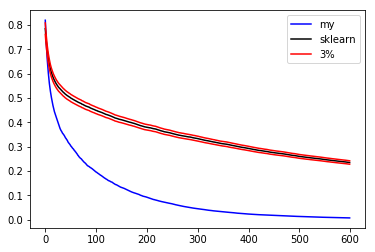

In [58]:
fig, ax = plt.subplots()

ax.plot(np.array(gdb.get_scores())[0:], color='blue', label='my')
ax.plot(sk_gdb.train_score_[0:], color='black', label='sklearn')
ax.plot(sk_gdb.train_score_[0:] * 1.03, color='red', label='3%')
ax.plot(sk_gdb.train_score_[0:] * 0.97, color='red')
ax.legend()
plt.show()

In [59]:
test_data_norm = (test_data - medians) / iqrs

In [60]:
test_predict = sk_gdb.staged_predict(test_data)

In [61]:
test_scores = []
for y1 in test_predict:
    test_scores.append(((y1 - test_target) ** 2).mean())
test_scores = np.array(test_scores)

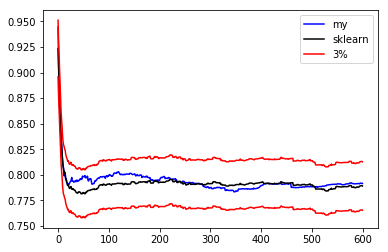

In [62]:
fig, ax = plt.subplots()

ax.plot(np.array(gdb.staged_scores(test_data_norm, test_target)), color='blue', label='my')
ax.plot(test_scores, color='black', label='sklearn')
ax.plot(test_scores * 1.03, color='red', label='3%')
ax.plot(test_scores * 0.97, color='red')
ax.legend()
plt.show()

In [120]:
arr = np.array([[1, 2, 3], [2, 0, 4]])
np.median(arr, axis=0)

array([ 1.5,  1. ,  3.5])

In [121]:
np.subtract(*np.percentile(arr, q=[75, 25], axis=0))

array([ 0.5,  1. ,  0.5])

In [122]:
np.percentile(arr, q=[75, 25], axis=0)

array([[ 1.75,  1.5 ,  3.75],
       [ 1.25,  0.5 ,  3.25]])

In [128]:
arr - np.mean(arr, axis=0) / np.subtract(*np.percentile(arr, q=[75, 25], axis=0))

array([[-2.,  1., -4.],
       [-1., -1., -3.]])

In [36]:
np.array([1, 2]).dot(arr)

array([ 5,  2, 11])

In [51]:
np.argwhere(np.array([1, 2, 3, -1]) > 0).reshape(1, -1)

array([[0, 1, 2]])

In [48]:
arr[0]

array([1, 2, 3])

In [48]:
np.array([1, 2]).dot(arr)

array([ 5,  2, 11])

In [49]:
np.dot(np.array([1, 2]), arr)

array([ 5,  2, 11])

In [52]:
np.dot(arr, np.array([1, 2]).reshape(1, -1))

ValueError: shapes (2,3) and (1,2) not aligned: 3 (dim 1) != 1 (dim 0)

In [85]:
np.array([-1, 2, 3]) / 0.0 == np.inf

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


array([False,  True,  True], dtype=bool)

In [15]:
np.divide(np.array([1, 2]), np.array([0, 1]))

array([ inf,   2.])

In [12]:
np.seterr(divide='ignore')

{'divide': 'ignore', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [19]:
np.logical_not(np.array([0, 1, 0]))

array([ True, False,  True], dtype=bool)